# Linear & non-linear limit of diffusion under OU policy
## TOC:
* [Comparison of analytical results and numerics of OU process in linear limit](#first-bullet)
* [Computing diffusion of the agent in the non-linear limit](#second-bullet)

In [73]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy

import jax.numpy as jnp
import jax
from jax import random
from jax import jit
from jax import vmap
from jax import lax
from jax.tree_util import register_pytree_node

import time
import random as rm
import pandas as pd

In [74]:
colors = {
    "gray": {
        0: "#f8f9fa",
        1: "#f1f3f5",
        2: "#e9ecef",
        3: "#dee2e6",
        4: "#ced4da",
        5: "#adb5bd",
        6: "#868e96",
        7: "#495057",
        8: "#343a40",
        9: "#212529",
    },
    "red": {
        0: "#fff5f5",
        1: "#ffe3e3",
        2: "#ffc9c9",
        3: "#ffa8a8",
        4: "#ff8787",
        5: "#ff6b6b",
        6: "#fa5252",
        7: "#f03e3e",
        8: "#e03131",
        9: "#c92a2a",
    },
    "pink": {
        0: "#fff0f6",
        1: "#ffdeeb",
        2: "#fcc2d7",
        3: "#faa2c1",
        4: "#f783ac",
        5: "#f06595",
        6: "#e64980",
        7: "#d6336c",
        8: "#c2255c",
        9: "#a61e4d",
    },
    "grape": {
        0: "#f8f0fc",
        1: "#f3d9fa",
        2: "#eebefa",
        3: "#e599f7",
        4: "#da77f2",
        5: "#cc5de8",
        6: "#be4bdb",
        7: "#ae3ec9",
        8: "#9c36b5",
        9: "#862e9c",
    },
    "violet": {
        0: "#f3f0ff",
        1: "#e5dbff",
        2: "#d0bfff",
        3: "#b197fc",
        4: "#9775fa",
        5: "#845ef7",
        6: "#7950f2",
        7: "#7048e8",
        8: "#6741d9",
        9: "#5f3dc4",
    },
    "indigo": {
        0: "#edf2ff",
        1: "#dbe4ff",
        2: "#bac8ff",
        3: "#91a7ff",
        4: "#748ffc",
        5: "#5c7cfa",
        6: "#4c6ef5",
        7: "#4263eb",
        8: "#3b5bdb",
        9: "#364fc7",
    },
    "blue": {
        0: "#e7f5ff",
        1: "#d0ebff",
        2: "#a5d8ff",
        3: "#74c0fc",
        4: "#4dabf7",
        5: "#339af0",
        6: "#228be6",
        7: "#1c7ed6",
        8: "#1971c2",
        9: "#1864ab",
    },
    "cyan": {
        0: "#e3fafc",
        1: "#c5f6fa",
        2: "#99e9f2",
        3: "#66d9e8",
        4: "#3bc9db",
        5: "#22b8cf",
        6: "#15aabf",
        7: "#1098ad",
        8: "#0c8599",
        9: "#0b7285",
    },
    "teal": {
        0: "#e6fcf5",
        1: "#c3fae8",
        2: "#96f2d7",
        3: "#63e6be",
        4: "#38d9a9",
        5: "#20c997",
        6: "#12b886",
        7: "#0ca678",
        8: "#099268",
        9: "#087f5b",
    },
    "green": {
        0: "#ebfbee",
        1: "#d3f9d8",
        2: "#b2f2bb",
        3: "#8ce99a",
        4: "#69db7c",
        5: "#51cf66",
        6: "#40c057",
        7: "#37b24d",
        8: "#2f9e44",
        9: "#2b8a3e",
    },
    "lime": {
        0: "#f4fce3",
        1: "#e9fac8",
        2: "#d8f5a2",
        3: "#c0eb75",
        4: "#a9e34b",
        5: "#94d82d",
        6: "#82c91e",
        7: "#74b816",
        8: "#66a80f",
        9: "#5c940d",
    },
    "yellow": {
        0: "#fff9db",
        1: "#fff3bf",
        2: "#ffec99",
        3: "#ffe066",
        4: "#ffd43b",
        5: "#fcc419",
        6: "#fab005",
        7: "#f59f00",
        8: "#f08c00",
        9: "#e67700",
    },
    "orange": {
        0: "#fff4e6",
        1: "#ffe8cc",
        2: "#ffd8a8",
        3: "#ffc078",
        4: "#ffa94d",
        5: "#ff922b",
        6: "#fd7e14",
        7: "#f76707",
        8: "#e8590c",
        9: "#d9480f",
    },
    "mixed": {
        0: "#880e4f",
        1: "#1a237e",
        2: "#e65100",
        3: "#004d40",
        4: "#c92a2a",
    },
}

Dynamics of an agent whose orientation is described by the Ornstein-Uhlenbeck process is given by

$
\dot{\theta}(t) = - \alpha \theta(t) + \sqrt{2D} \eta(t)
$

$
\langle \eta(t) \eta(t') \rangle = \delta(t-t')
$

In [75]:
# Parameters in the model
class params():
    def __init__(self) -> None:
        super().__init__()
        self.nSteps = 800
        self.nEpchs = 500
        
        self.dt = 1e-2
        self.l = 5e-3
        self.vo = self.l/self.dt
        self.alpha = 50
        self.diff = 30/jnp.pi
        
        self.rInit = jnp.array([0.0, 0.0])
        self.thInit = 0.

In [76]:
# Single step dynamics of the agent
class agent():
    def __init__(self, r, thet, rng):
        super().__init__()
        self.r = r
        self.thet = thet
        self.rng = rng
    
    @jit
    def stepFwd(self, dt, l, diff, alpha):
        drng = random.split(self.rng)[0]
        # self.r += l*jnp.array([jnp.cos(self.thet), jnp.sin(self.thet)])
        self.r += l*jnp.array([1., self.thet])
        self.thet = self.thet*(1-alpha*dt) + jnp.sqrt(2*diff*dt)*random.normal(drng)
        return agent(self.r, self.thet, drng)
    
register_pytree_node(agent,
                     lambda x: ((x.r[0], x.r[1], x.thet, x.rng), None),
                     lambda _, tup: agent(jnp.array([tup[0], tup[1]]), tup[2], tup[3]))

 ## <a class="anchor" id="first-bullet">Single epoch of agent dynamics</a>

--- 0.8859591484069824 seconds ---


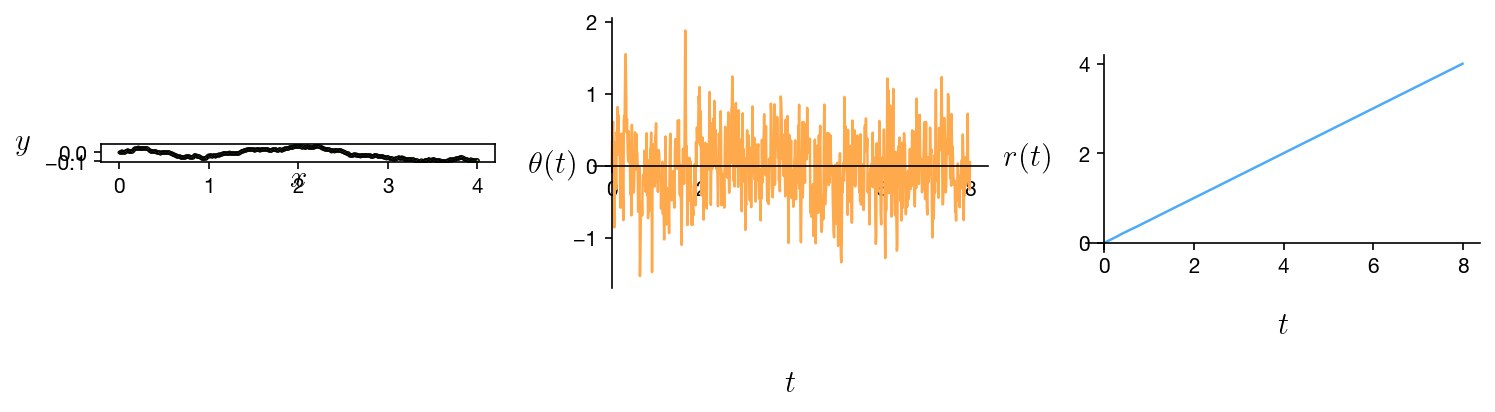

In [78]:
# Single epoch of agent dynamics for p.nSteps
rng = random.PRNGKey(rm.randint(0,10000))
p = params()
ag = agent(p.rInit, p.thInit, rng)
start_time = time.time()
rxFull = np.array(p.rInit[0])
ryFull = np.array(p.rInit[1])
thetFull = np.array(p.thInit)

dfx = pd.DataFrame()
dfy = pd.DataFrame()

for i in range(p.nSteps):
    ag = ag.stepFwd(p.dt, p.l, p.diff, p.alpha)
    rxFull = np.vstack((rxFull, np.array(ag.r[0])))
    ryFull = np.vstack((ryFull, np.array(ag.r[1])))
    thetFull = np.vstack((thetFull, np.array(ag.thet)))
    # dfx[i] = rxFull.tolist()
    # dfy[i] = ryFull.tolist()
print("--- %s seconds ---" % (time.time() - start_time))

dfx = pd.DataFrame(rxFull)
dfy = pd.DataFrame(ryFull)

mpl.rcParams.update(mpl.rcParamsDefault)
plt.rc("font", family="Helvetica Neue")
plt.rc("xtick", labelsize="medium")

linewidth = 1.2
linestyle = "-"
label_size = 15
color = '#8dc63f'

fig = plt.figure(figsize=(10, 3), dpi=150)

nrows, ncols = 2, 2
gspec = gridspec.GridSpec(
    ncols=ncols, nrows=nrows, figure=fig, width_ratios=[1, 1], height_ratios=[1, 1]
)

nRow = 1
nCol = 3
ax1 = plt.subplot(nRow, nCol, 1, aspect=1)
ax1.scatter(rxFull, ryFull,
            s=2,
            color=color,
            edgecolors='k',
            linewidth=0.5,
            zorder=-1)
ax1.set_xlabel(r'$x$',usetex=True, fontsize=label_size)
ax1.set_ylabel(r'$y$',usetex=True,rotation=0, fontsize=label_size)

ax1.xaxis.set_label_coords(0.5,-0.1)
ax1.yaxis.set_label_coords(-0.2,0.4)


ax2 = plt.subplot(nRow, nCol, 2)
t = jnp.arange(p.nSteps)*p.dt
# ax2.plot(t, np.mod(thetFull[:-1],2*np.pi),
ax2.plot(t, thetFull[:-1],
        color=colors['orange'][4],
        clip_on=False,
        linewidth=linewidth,
        linestyle=linestyle,)
ax2.set_xlabel(r'$t$',usetex=True, fontsize=label_size)
ax2.set_ylabel(r'$\theta(t)$',usetex=True,rotation=0, fontsize=label_size)
# ax2.set_ylim([0.,2*np.pi])

ax2.xaxis.set_label_coords(0.5,-0.3)
ax2.yaxis.set_label_coords(-0.1,0.4)

ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.spines["left"].set_position(("data", 0))
ax2.spines["bottom"].set_position(("data", 0))

ax3 = plt.subplot(nRow, nCol, 3, aspect=1)
ax3.plot(t, np.sqrt(rxFull[:-1]**2 + ryFull[:-1]**2),
        color=colors['blue'][4],
        clip_on=False,
        linewidth=linewidth,
        linestyle=linestyle,)
ax3.set_xlabel(r'$t$',usetex=True, fontsize=label_size)
ax3.set_ylabel(r'$r(t)$',usetex=True,rotation=0, fontsize=label_size)
# ax3.set_ylim([0.,2*np.pi])

ax3.xaxis.set_label_coords(0.5,-0.3)
ax3.yaxis.set_label_coords(-0.15,0.4)

ax3.spines["right"].set_visible(False)
ax3.spines["top"].set_visible(False)
ax3.spines["left"].set_position(("data", 0))
ax3.spines["bottom"].set_position(("data", 0))


plt.tight_layout()
plt.show()

 ## <a class="anchor" id="second-bullet">Several epochs of dynamics</a>

In [79]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rc("font", family="Helvetica Neue")
plt.rc("xtick", labelsize="medium")

linewidth = 1.2
linestyle = "-"
label_size = 15
color = '#8dc63f'

fig = plt.figure(figsize=(10, 3), dpi=150)

nrows, ncols = 2, 2
gspec = gridspec.GridSpec(
ncols=ncols, nrows=nrows, figure=fig, width_ratios=[1, 1], height_ratios=[1, 1]
)

p = params()
dfx = pd.DataFrame()
dfy = pd.DataFrame()
# for ind in np.arange(p.nEpchs):
for ind in np.arange(1000):
    rng = random.PRNGKey(rm.randint(0,10000))
    ag = agent(p.rInit, p.thInit, rng)
    rxFull = np.array(p.rInit[0])
    ryFull = np.array(p.rInit[1])
    thetFull = np.array(p.thInit)
    for i in range(p.nSteps):
        ag = ag.stepFwd(p.dt, p.l, p.diff, p.alpha)
        rxFull = np.vstack((rxFull, ag.r[0]))
        ryFull = np.vstack((ryFull, np.array(ag.r[1])))
        thetFull = np.vstack((thetFull, np.array(ag.thet)))
    dfx[ind] = rxFull.flatten().tolist()
    dfy[ind] = ryFull.flatten().tolist()
    nRow = 1
    nCol = 3
    ax1 = plt.subplot(nRow, nCol, 1, aspect=1)

    ax1.scatter(rxFull, ryFull,
                s=2,
                color=color,
                edgecolors='k',
                linewidth=0.5,
                zorder=-1)
    ax1.set_xlabel(r'$x$',usetex=True, fontsize=label_size)
    ax1.set_ylabel(r'$y$',usetex=True,rotation=0, fontsize=label_size)

    ax1.xaxis.set_label_coords(0.5,-0.1)
    ax1.yaxis.set_label_coords(-0.2,0.4)


    ax2 = plt.subplot(nRow, nCol, 2)
    t = jnp.arange(p.nSteps)*p.dt
    ax2.plot(t, thetFull[:-1],
            color=colors['orange'][4],
            clip_on=False,
            linewidth=linewidth,
            linestyle=linestyle,)
    ax2.set_xlabel(r'$t$',usetex=True, fontsize=label_size)
    ax2.set_ylabel(r'$\theta(t)$',usetex=True,rotation=0, fontsize=label_size)

    ax2.xaxis.set_label_coords(0.5,-0.3)
    ax2.yaxis.set_label_coords(-0.1,0.4)

    ax2.spines["right"].set_visible(False)
    ax2.spines["top"].set_visible(False)
    ax2.spines["left"].set_position(("data", 0))
    ax2.spines["bottom"].set_position(("data", 0))

    ax3 = plt.subplot(nRow, nCol, 3, aspect=1)
    ax3.plot(t, np.sqrt(rxFull[:-1]**2 + ryFull[:-1]**2),
            color=colors['blue'][4],
            clip_on=False,
            linewidth=linewidth,
            linestyle=linestyle,)
    ax3.set_xlabel(r'$t$',usetex=True, fontsize=label_size)
    ax3.set_ylabel(r'$r(t)$',usetex=True,rotation=0, fontsize=label_size)
    ax3.xaxis.set_label_coords(0.5,-0.3)
    ax3.yaxis.set_label_coords(-0.15,0.4)

    ax3.spines["right"].set_visible(False)
    ax3.spines["top"].set_visible(False)
    ax3.spines["left"].set_position(("data", 0))
    ax3.spines["bottom"].set_position(("data", 0))


plt.tight_layout()
plt.show()

/var/folders/hq/qfn7h8h16pvdp93670td9g8w0000gn/T/ipykernel_25734/1586216806.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dfx[ind] = rxFull.flatten().tolist()
/var/folders/hq/qfn7h8h16pvdp93670td9g8w0000gn/T/ipykernel_25734/1586216806.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dfy[ind] = ryFull.flatten().tolist()
/var/folders/hq/qfn7h8h16pvdp93670td9g8w0000gn/T/ipykernel_25734/1586216806.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

KeyboardInterrupt: 

In [38]:
dfx

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,...,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000
2,0.009924,0.009792,0.009970,0.009116,0.009062,0.009582,0.009804,0.009926,0.008501,0.009561,...,0.009700,0.009954,0.009925,0.005015,0.009695,0.009998,0.009333,0.008835,0.009784,0.009045
3,0.014920,0.014744,0.014587,0.013385,0.013775,0.013910,0.014726,0.014634,0.010528,0.014560,...,0.013118,0.014552,0.013694,0.009980,0.013790,0.014991,0.013233,0.013229,0.014212,0.013781
4,0.018334,0.019440,0.017625,0.018288,0.017817,0.018257,0.019723,0.019342,0.014945,0.019482,...,0.018115,0.019374,0.016564,0.014932,0.018752,0.019797,0.018214,0.017142,0.019004,0.018781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,3.472152,3.487019,3.424599,3.472825,3.548939,3.519009,3.500764,3.459735,3.500425,3.518842,...,3.474302,3.564568,3.513137,3.536188,3.443433,3.500880,3.495509,3.466959,3.487168,3.549829
797,3.477131,3.490938,3.428698,3.477800,3.552076,3.523864,3.504313,3.464700,3.505394,3.523002,...,3.479251,3.569541,3.517172,3.541186,3.447584,3.505872,3.500188,3.471795,3.492101,3.553469
798,3.481711,3.495766,3.433566,3.482771,3.556533,3.526989,3.509307,3.469404,3.510127,3.527534,...,3.484222,3.574115,3.521505,3.545174,3.452514,3.510126,3.503844,3.475767,3.496250,3.558426
799,3.486189,3.500446,3.438462,3.487544,3.561073,3.531431,3.514237,3.469087,3.515121,3.532526,...,3.489114,3.577567,3.525993,3.549278,3.456893,3.511705,3.504797,3.480641,3.500314,3.562227


In [80]:
dfy

,0,1,2,3,4,5,6,7,8,9,...,372,373,374,375,376,377,378,379,380,381
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.003397,0.001334,-0.000078,-0.001586,-0.000319,0.002693,-0.000435,0.001374,0.001340,-0.002265,...,-0.002626,0.003582,-0.001270,0.000810,-0.003020,-0.001536,-0.001726,0.000423,0.000255,-0.001545
3,0.006275,0.000937,0.001528,-0.001835,0.001102,-0.000485,-0.001207,0.002666,0.001236,-0.004659,...,-0.010551,0.007004,-0.001266,0.001947,-0.006767,-0.002289,-0.003740,0.002663,0.003312,-0.003687
4,0.010106,0.001267,0.003040,-0.003477,0.001318,-0.002339,-0.003176,0.002904,0.000524,-0.005786,...,-0.014451,0.008609,-0.001186,0.005553,-0.006274,0.003209,-0.002605,0.007865,0.004017,-0.007113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,-0.005960,0.029830,-0.179342,0.016401,0.029820,0.007411,0.060799,-0.007137,0.032784,0.183170,...,-0.120373,0.017984,0.078477,0.059746,0.045151,-0.420314,0.144049,-0.009119,-0.005797,-0.142632
797,-0.003867,0.032528,-0.180867,0.018983,0.028429,0.008257,0.058990,-0.007557,0.029189,0.185012,...,-0.122086,0.019038,0.079395,0.057996,0.047602,-0.418404,0.145562,-0.015400,-0.006611,-0.145600
798,-0.002793,0.033368,-0.182558,0.018787,0.024529,0.011060,0.062492,-0.009395,0.026252,0.184748,...,-0.124975,0.018217,0.076828,0.053079,0.050722,-0.420932,0.146225,-0.019295,-0.003746,-0.144947
799,-0.000431,0.032521,-0.184145,0.022298,0.021170,0.010789,0.065421,-0.010589,0.022878,0.185902,...,-0.124667,0.018500,0.075382,0.048185,0.047617,-0.424436,0.146847,-0.020289,-0.004744,-0.140609


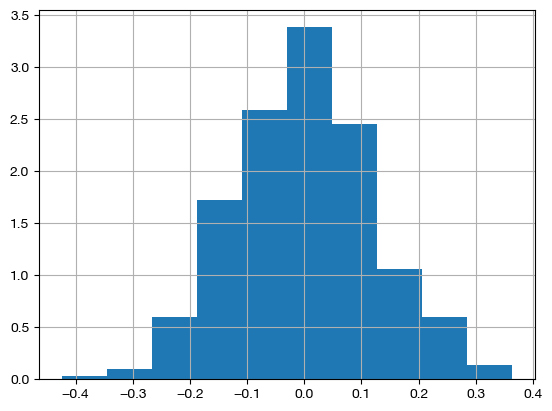

In [82]:
dfy.iloc[800,:].hist(bins=10, density = True)
plt.show()

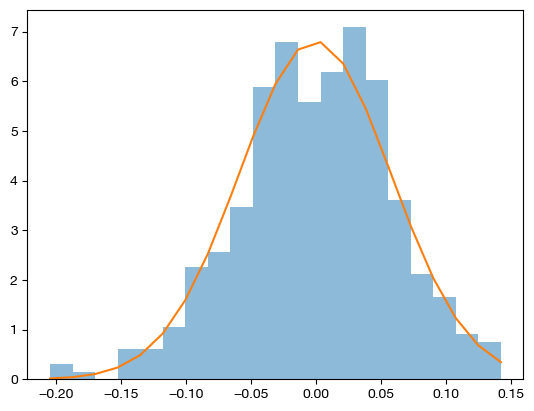

In [83]:
ind = 200
_, bins, _ = plt.hist(dfy.iloc[ind,:], 20, density=1, alpha=0.5)
mu, sigma = scipy.stats.norm.fit(dfy.iloc[ind,:])
best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
plt.plot(bins, best_fit_line)
plt.show()

/Users/kalyani/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2085: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/kalyani/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2085: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


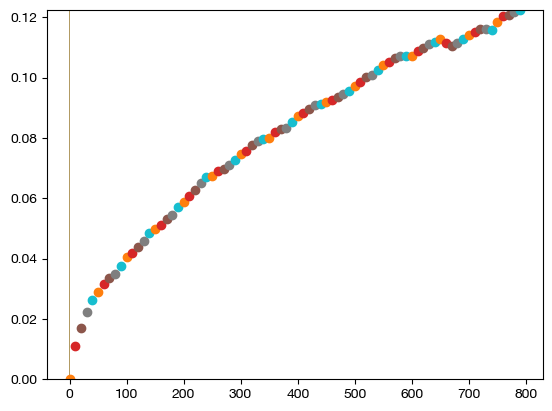

In [84]:
for ind in np.arange(0,800,10):
    _, bins, _ = plt.hist(dfy.iloc[ind,:], 20, density=1, alpha=0.5)
    mu, sigma = scipy.stats.norm.fit(dfy.iloc[ind,:])
    best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
    plt.plot(ind, sigma,'o')
plt.ylim([0, sigma])
plt.show()

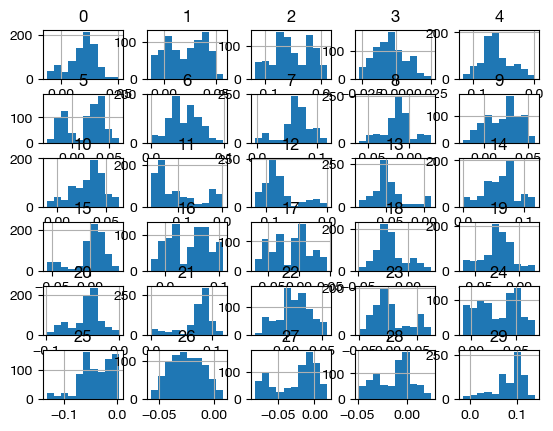

In [134]:
dfy.hist(bins=10)
plt.show()

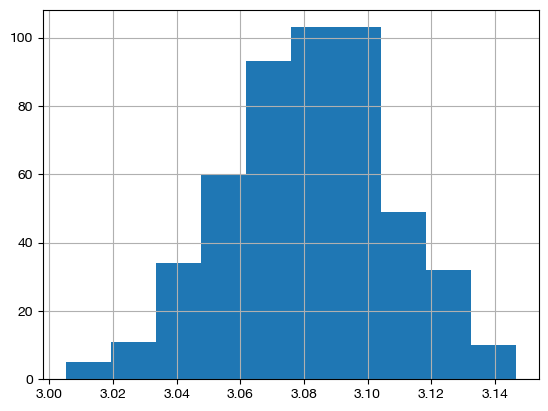

In [52]:
dfx.iloc[700,:].hist(bins=10)
plt.show()